#**Data Science Code Challenge** 

## Create a forecast of the number of chats for the month of July.
Because our main goal is predict and forcast the chats demand, so I will consider the paid_employees as an additional information and we could discuss it later. We will focus on the chats'changes over the time first. 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("chat_demand.csv")
df.head()


,date,paid_employees,chats
0,2018-01-01,10000,61
1,2018-01-02,10000,126
2,2018-01-03,10000,119
3,2018-01-04,10000,118
4,2018-01-05,10000,117


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   date            181 non-null    object
 1   paid_employees  181 non-null    int64 
 2   chats           181 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 4.4+ KB


In [ ]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
##df

In [ ]:
df = df.set_index('date')

In [ ]:
df.shape

(181, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 181 entries, 2018-01-01 to 2018-06-30
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   paid_employees  181 non-null    int64
 1   chats           181 non-null    int64
dtypes: int64(2)
memory usage: 4.2 KB


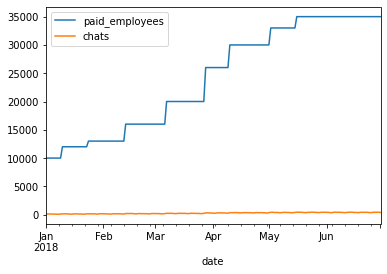

In [ ]:
df.plot()

The number of users that have access to the platform(paid employees) gradually increasing over the time. However, due to the different range, we couldn't clear detect the symptoms of chats(demand). So we use other method to further explore it. 

##Data Exploratory

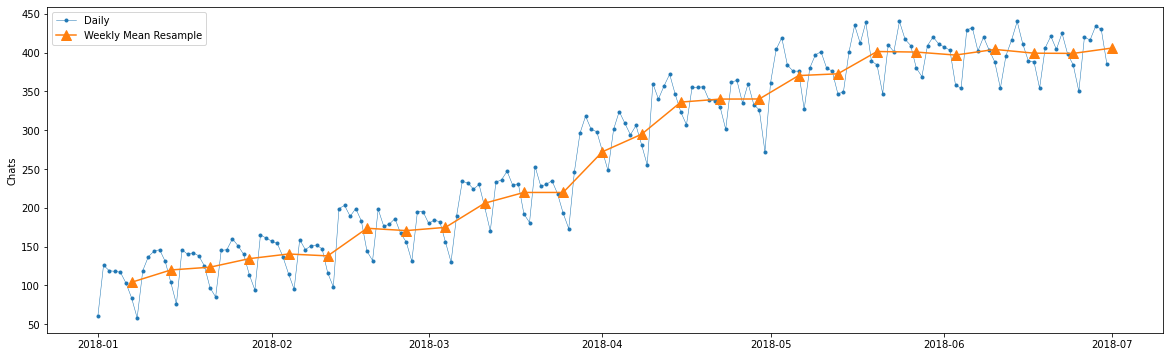

In [ ]:

import matplotlib.pyplot as plt
y = df['chats']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(y.resample('W').mean(),marker='^', markersize=10, linestyle='-', label='Weekly Mean Resample')
ax.set_ylabel('Chats')
ax.legend();

Based on the graph of chats above, we could see a increasing trend with no clear pattern of seasonal or cyclical changes. To figure out more of the complexity, we will decompose the seasonal data by statsmodels' package.



In [ ]:
import statsmodels.api as sm

#show decompose of seasonal data
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


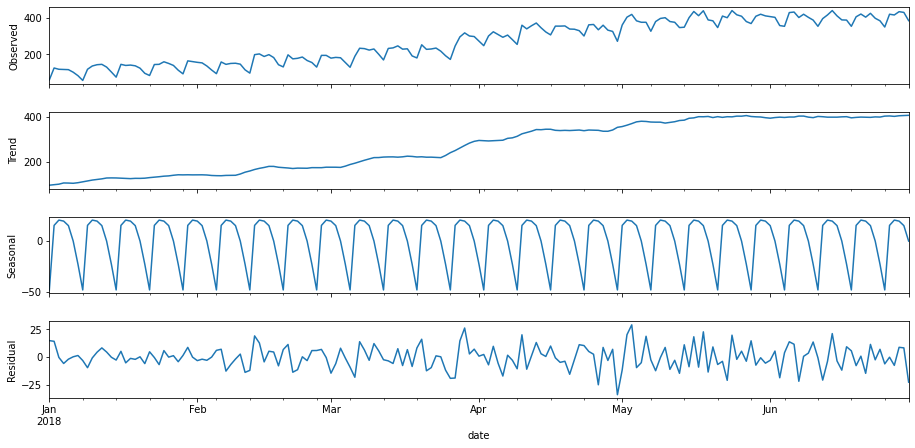

In [ ]:
seasonal_decompose(y)

Based on the above 4 graphs, It is clear that our chats demand has an overall increasing trend as well as a weekly seasonality. 

# Check for Stationarity

We will use Visualization method and the Augmented Dickey-Fuller (ADF) Test to check the stationarity of our data.



In [ ]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rollmean = pd.Series(timeseries).rolling(window=12).mean() 
    rollstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(17, 5))
    ax.plot(timeseries, label= title)
    ax.plot(rollmean, label='rolling mean');
    ax.plot(rollstd, label='rolling std (x10)');
    ax.legend()

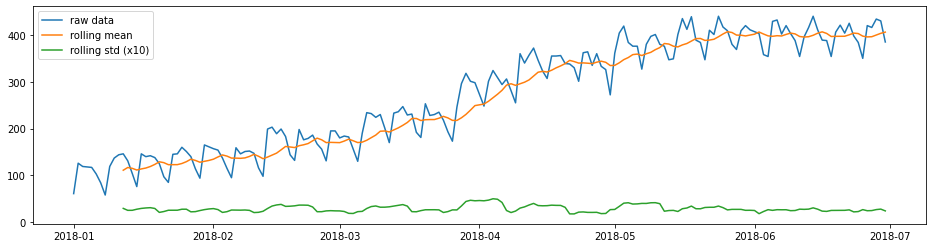

In [ ]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'raw data')

The standard deviation for stationary data does not change much over time. But the mean has a clear increasing trend over time. 
We should do another test of stationarity to double check it.

In [ ]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print('Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [ ]:
ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = -1.041
P-value = 0.738
Critical values :
	1%: -3.4703698981001665 - The data is not stationary with 99% confidence
	5%: -2.8791138497902193 - The data is not stationary with 95% confidence
	10%: -2.576139407751488 - The data is not stationary with 90% confidence


By looking at both tests, we could tell that our chats data is non-stationary. 

#Stationarize
In order to do the time series analysis, we need to stationarize the dataset. Because the trend is obvious, we choose to detrend it first. 

### Detrending
Here we choose 6 or 11 because them give us the lowest P value and it is close to the weekly seasonality. We could run further steps to decide the better one. 

Is the de-trended data stationary ?
Test statistic = -2.848
P-value = 0.052
Critical values :
	1%: -3.471633386932248 - The data is not stationary with 99% confidence
	5%: -2.8796651107461972 - The data is not stationary with 95% confidence
	10%: -2.576433647235832 - The data is  stationary with 90% confidence


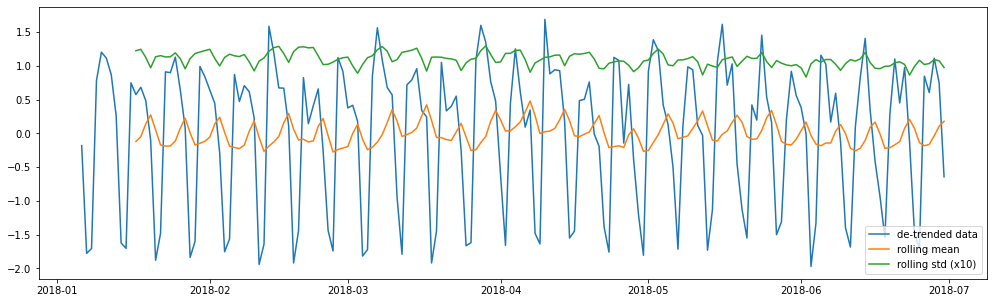

In [ ]:
y_detrend =  (y - y.rolling(window=6).mean())/y.rolling(window=6).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

The de trend data looks follow a specific pattern and the mean and standard deviation looks stationary. The data is stationary with 90% CI. But it is not stationary with 99% and 95% CI. 

### Lag Differencing
Because time series data is using the previous data to predict the later data, we could check the lag difference to understand seasonal or cyclical patterns in the time series. Since the sample dataset has a weekly seasonality, we try 7 first. 

Is the de-trended data stationary ?
Test statistic = -3.100
P-value = 0.027
Critical values :
	1%: -3.4729792729247793 - The data is not stationary with 99% confidence
	5%: -2.8802520918255534 - The data is  stationary with 95% confidence
	10%: -2.5767469641683105 - The data is  stationary with 90% confidence


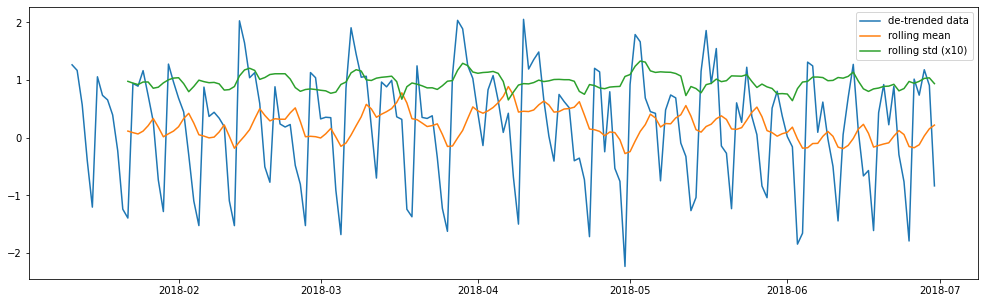

In [ ]:
y_detrend2 =  (y - y.rolling(window=11).mean())/y.rolling(window=11).std()

test_stationarity(y_detrend2,'de-trended data')
ADF_test(y_detrend2,'de-trended data')

11 lag is not stationary within 99 percent of the confidence interval.

Is the 6 lag differenced data stationary ?
Test statistic = -4.063
P-value = 0.001
Critical values :
	1%: -3.4718957209472654 - The data is  stationary with 99% confidence
	5%: -2.8797795410156253 - The data is  stationary with 95% confidence
	10%: -2.5764947265625 - The data is  stationary with 90% confidence


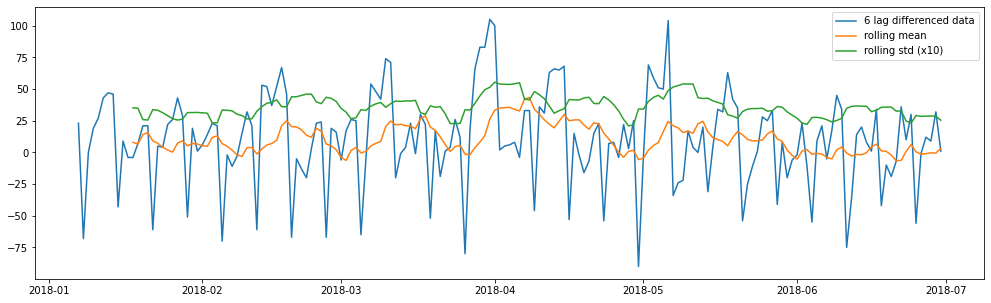

In [ ]:
y_6lag =  y - y.shift(6)

test_stationarity(y_6lag,'6 lag differenced data')
ADF_test(y_6lag,'6 lag differenced data')

After 6 lag differencing, the data is now stationary.

### Combining Detrending and Differencing


In [ ]:
y_6lag_detrend =  y_detrend - y_detrend.shift(6)

test_stationarity(y_6lag_detrend,'6 lag differenced de-trended data')
ADF_test(y_6lag_detrend,'6 lag differenced de-trended data')

Using the combination of the two methods, we see from both the visualization and the ADF test that the data is now stationary. This is the transformation we will use moving forward with our analysis.

## Then we start to choose a suitable Prediction Model to fit and train our data.
Usually we use 7:3 split, however, we have limited data sample, so we use first 5 months sample to train and the last month to test.

In [ ]:
y_to_train = y[:'2018-05-30'] # dataset to train
y_to_val = y['2018-05-30':] # last X months for test  
predict_date = len(y) - len(y[:'2018-05-30']) 

In [ ]:
y_to_train2 = y_detrend2[:'2018-05-30'] # dataset to train
y_to_val2 = y_detrend2['2018-05-30':] # last X months for test  
predict_date2 = len(y_detrend2) - len(y_6lag_detrend[:'2018-05-30']) 

### Usually we start from Simple Exponential Smoothing(SES)
Used for time series data with no trend or seasonal pattern

This method prerdict the forecasting data based on weighted averages of historical data.
Smoothing level a represent the how close the forcasting to the historical average. When α = 0, equal to average. When α = 1, the forecasts will be only equal to last observation.
The auto-optimization from statsmodels would give a lowest RMSE smoothing value. 

In [ ]:
from statsmodels.tsa.api import SimpleExpSmoothing 

def ses(y, y_to_train,y_to_test,smoothing_level,predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(15, 10))
    
    fit1 = SimpleExpSmoothing(y_to_train).fit(smoothing_level=smoothing_level,optimized=False)
    fcast1 = fit1.forecast(predict_date).rename(r'$\alpha={}$'.format(smoothing_level))
    # specific smoothing level
    fcast1.plot(marker='o', color='blue', legend=True)
    fit1.fittedvalues.plot(marker='o',  color='blue')
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with smoothing level of {} is {}'.format(smoothing_level,round(np.sqrt(mse1), 2)))
    
    ## auto optimization
    fit2 = SimpleExpSmoothing(y_to_train).fit()
    fcast2 = fit2.forecast(predict_date).rename(r'$\alpha=%s$'%fit2.model.params['smoothing_level'])
    # plot
    fcast2.plot(marker='o', color='green', legend=True)
    fit2.fittedvalues.plot(marker='o', color='green')
    
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with auto optimization is {}'.format(round(np.sqrt(mse2), 2)))
    
    plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


The Root Mean Squared Error of our forecasts with smoothing level of 0.7 is 28.29
The Root Mean Squared Error of our forecasts with auto optimization is 28.78


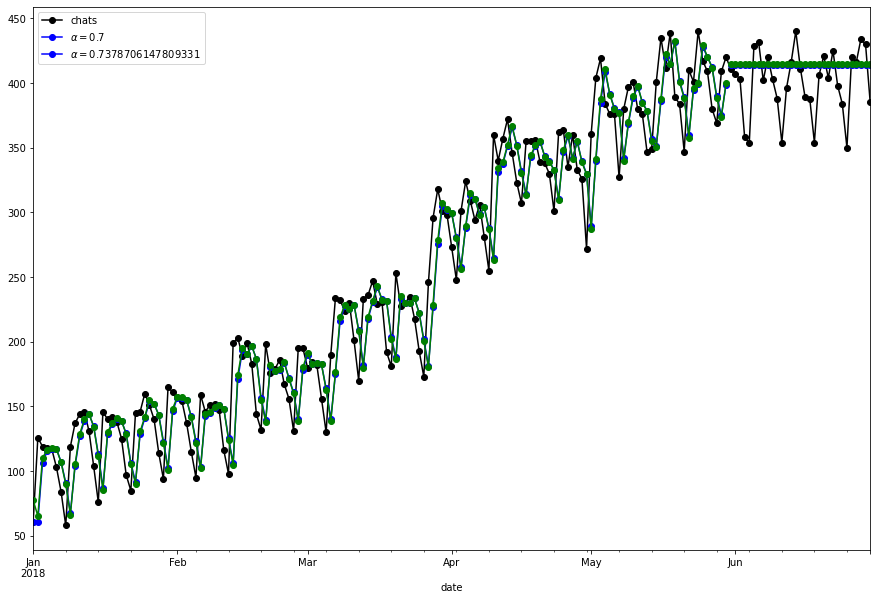

In [ ]:
ses(y, y_to_train,y_to_val,0.7,predict_date)

The error seems not so big, however, based on the graph above this is definetly not we are looking for. The forcasting chats only located around the average number and without any fluctuation. We could use it as a baseline. Then we should try other method. 

### Holt
Mainly used for time series data with a trend component
Similar as alpha in the ses model, beta play as a trending smoothing level. 

In [ ]:
from statsmodels.tsa.api import Holt

def holt(y,y_to_train,y_to_test,smoothing_level,smoothing_slope, predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(15, 10))
    
    fit1 = Holt(y_to_train).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast1 = fit1.forecast(predict_date).rename("Holt's linear trend")
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of Holt''s Linear trend {}'.format(round(np.sqrt(mse1), 2)))

    fit2 = Holt(y_to_train, exponential=True).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast2 = fit2.forecast(predict_date).rename("Exponential trend")
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of Holt''s Exponential trend {}'.format(round(np.sqrt(mse2), 2)))
    
    fit1.fittedvalues.plot(marker="o", color='blue')
    fcast1.plot(color='blue', marker="o", legend=True)
    #fit2.fittedvalues.plot(marker="o", color='r')
    #fcast2.plot(color='r', marker="o", legend=True)

    plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


The Root Mean Squared Error of Holts Linear trend 51.31
The Root Mean Squared Error of Holts Exponential trend 59.15


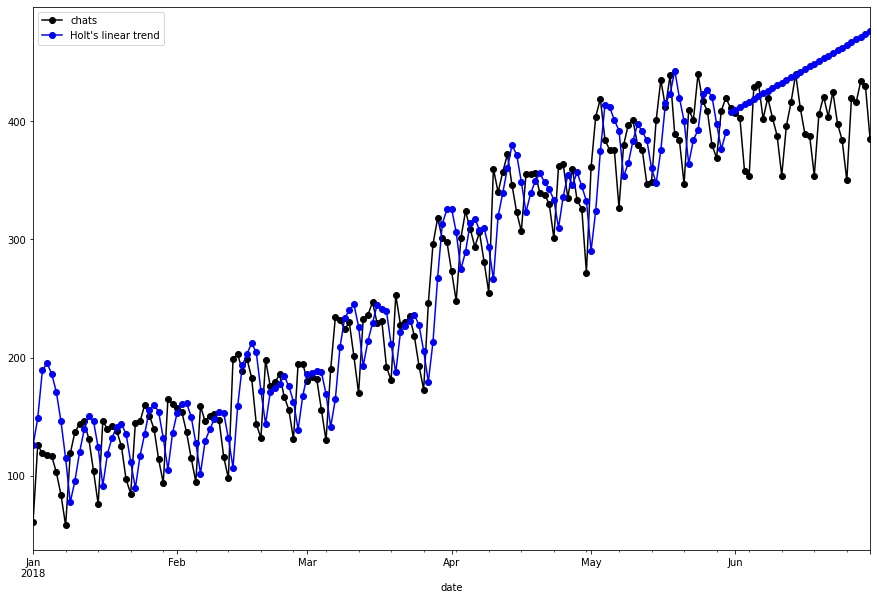

In [ ]:
holt(y, y_to_train,y_to_val,0.5,0.3,predict_date)

Holt truely capture the trend however, it is too straight and without flunctuation. 

###Holt-Winters’ Seasonal Method
Time series data with trend and/or seasonal components.
Now we consider them together. 
"The Holt-Winters model extends Holt to allow the forecasting of time series data that has both trend and seasonality, and this method includes this seasonality smoothing parameter: γ." 
[Reference](https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-two/#holt-winters%E2%80%99-seasonal-method)

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing

def holt_win_sea(y,y_to_train,y_to_test,seasonal_type,seasonal_period,predict_date):
    
    y.plot(marker='o', color='black', legend=True, figsize=(15, 9))
    
    if seasonal_type == 'additive':
        fit1 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add').fit(use_boxcox=True)
        fcast1 = fit1.forecast(predict_date).rename('Additive')
        mse1 = ((fcast1 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse1), 2)))
        
        fit2 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
        fcast2 = fit2.forecast(predict_date).rename('Additive+damped')
        mse2 = ((fcast2 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse2), 2)))
        
        fit1.fittedvalues.plot(style='--', color='red')
        fcast1.plot(style='--', marker='o', color='red', legend=True)
        fit2.fittedvalues.plot(style='--', color='green')
        fcast2.plot(style='--', marker='o', color='green', legend=True)
    
    elif seasonal_type == 'multiplicative':  
        fit3 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul').fit(use_boxcox=True)
        fcast3 = fit3.forecast(predict_date).rename('Multiplicative')
        mse3 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse3), 2)))
        
        fit4 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)
        fcast4 = fit4.forecast(predict_date).rename('Multiplicative+damped')
        mse4 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse4), 2)))
        
        fit3.fittedvalues.plot(style='--', color='red')
        fcast3.plot(style='--', marker='o', color='red', legend=True)
        fit4.fittedvalues.plot(style='--', color='green')
        fcast4.plot(style='--', marker='o', color='green', legend=True)
        
    else:
        print('Wrong Seasonal Type. Please choose between additive and multiplicative')

    plt.show()

Because we are pretty sure the seasonality is weekly we identify the frequency m related to 7. We tested and found that 28 gave us best result. 

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


The Root Mean Squared Error of additive trend, additive seasonal of period season_length=28 and a Box-Cox transformation 53.09


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


The Root Mean Squared Error of additive damped trend, additive seasonal of period season_length=28 and a Box-Cox transformation 22.03


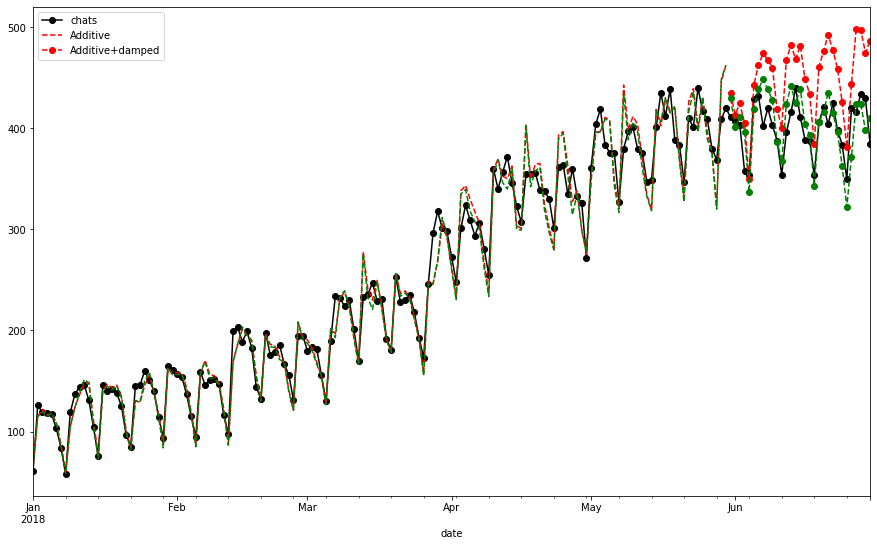

In [ ]:
holt_win_sea(y, y_to_train,y_to_val,'additive',28, predict_date)

Based on the visualization, we see that the Holt-Winters model fits the actual data best(damped trend), so far. However, the RMSE is not better too much than the results from the SES model. So we consider more complex model next. 



### SARIMA
By exploratory data analysis, we understand that our data has weekly seasonality, so we directly choosing Sarima rather than ARIMA.

Trend Elements:
p: Trend autoregression order.
d: Trend difference order.
q: Trend moving average order.
Seasonal Elements:

P: Seasonal autoregressive order.
D: Seasonal difference order.
Q: Seasonal moving average order.
m: The number of time steps for a single seasonal period.
[References of Parameters](https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/)

In [ ]:
import itertools

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [ ]:
sarima_grid_search(y,7)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packa

The set of parameters with the minimum AIC is: SARIMA(0, 1, 1)x(1, 1, 1, 7) - AIC:1360.23878015719


The grid search tested all possible combinations of variables, and we could find that SARIMA(0, 1, 1)x(1, 1, 1, 7) combination give the lowest AIC value. 
we will compare the results with all the previous models and choose the best one.



In [ ]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4771      0.068     -6.983      0.000      -0.611      -0.343
ar.S.L7       -0.2832      0.079     -3.597      0.000      -0.437      -0.129
ma.S.L7       -0.8845      0.061    -14.569      0.000      -1.003      -0.765
sigma2       210.5648     20.210     10.419      0.000     170.954     250.175


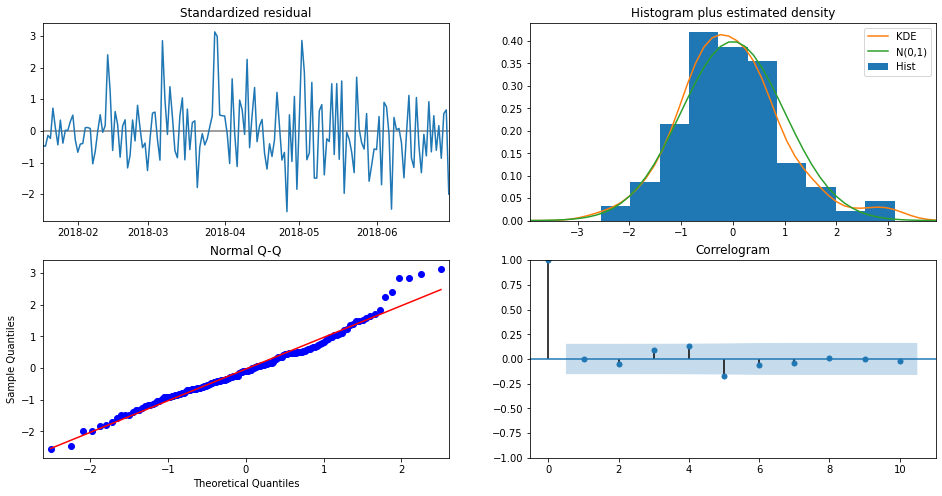

The Root Mean Squared Error of SARIMA with season_length=7 and dynamic = False 13.93


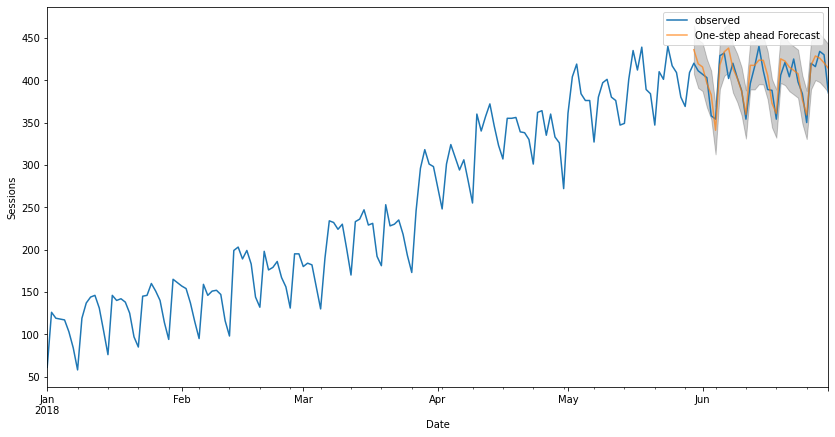

The Root Mean Squared Error of SARIMA with season_length=7 and dynamic = True 47.35


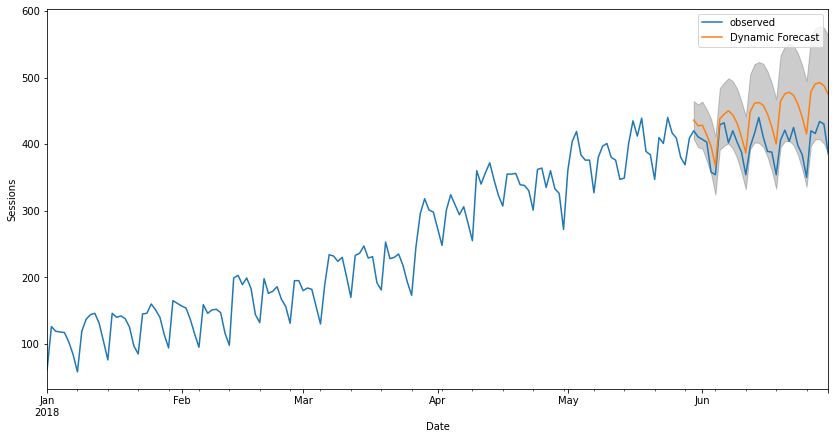

In [ ]:
model = sarima_eva(y,(0, 1, 1),(1, 1, 1, 7),7,'2018-05-30',y_to_val)

1. The first plot shows the residuals over time. The messier the better because we don't want to see any seasonality here. There is no significant trend or seasonality in our residual plot. 

2. In the second top plot, the KDE line follows the N(0,1) implies that the normally distributed. 

3. In the Normal QQ plot, we could also find that the residual mainly followed the Normal distribution.

4. "The autocorrelation visual (called a “correlogram”) on the bottom right shows the majority of dots fall into the blue shaded area implies that the time series residuals have a low correlation with the lagged versions of itself." 
[Autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation)

After analyzing all methods and their result, the Holt-Winters’Seasonal Method gives low result at around 22 with additive damped trend . However, if we consider the long term forecasting, The SARIMA give the better fit with one step ahead forecasting. 
The Root Mean Squared Error of SARIMA with season_length=7 and dynamic = False 13.93 
###So we choose this as our final model!

In [ ]:
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

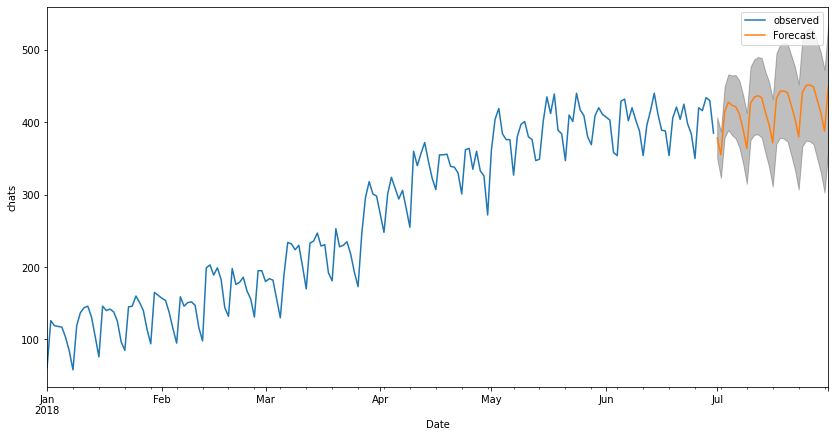

In [ ]:
final_table = forecast(model,31,y)


##The final number of chats for the month of July are shown below.

In [ ]:
final_table

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2018-07-01,378.326049,349.876751,406.775348
1,2018-07-02,355.126908,323.022969,387.230846
2,2018-07-03,414.148831,378.765847,449.531816
3,2018-07-04,427.657579,389.274663,466.040494
4,2018-07-05,423.436840,382.272037,464.601643
5,2018-07-06,421.378961,377.608723,465.149200
6,2018-07-07,411.140083,364.911013,457.369152
7,2018-07-08,390.169639,342.845530,437.493747
8,2018-07-09,363.912107,314.992744,412.831470
9,2018-07-10,426.042602,375.579215,476.505990


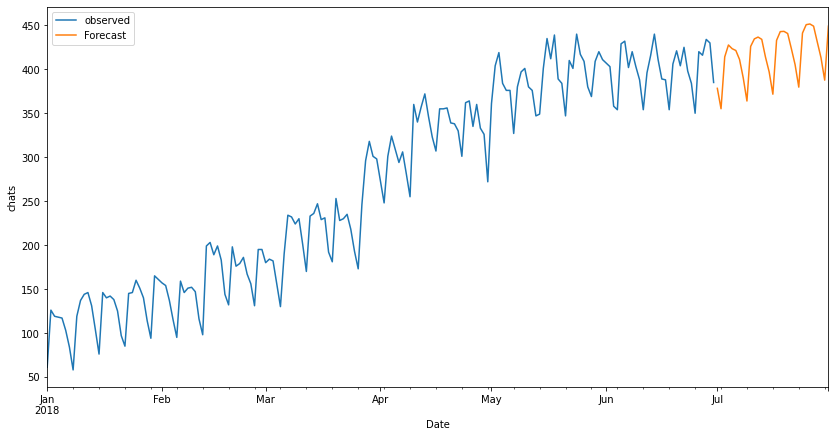

In [ ]:
pred_uc = model.get_forecast(steps=31)
ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel(y.name)

plt.legend()
plt.show()

##Advanced Architectures
In next chapter, we try to use machine learning methods to explore the potential models. 

# Machine learning Methods

In [ ]:
split_date = pd.Timestamp('05-30-2018')

In [ ]:
train = df.loc[:split_date, ['chats']]
test = df.loc[split_date:, ['chats']]

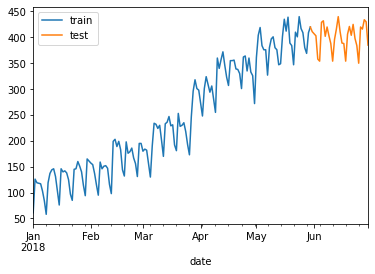

In [ ]:
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

Because the number of chats keep increasing and we are not sure how large it will go, so we choose to use minmaxscaler to control the range of input. It will preserve the shape of the dataset and it is better for plot. 

In [ ]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [ ]:
train_sc[:4], train_sc.shape

(array([[0.0078534 ],
        [0.17801047],
        [0.15968586],
        [0.15706806]]), (150, 1))

In [ ]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [ ]:
X_train.shape, y_train.shape

((149, 1), (149, 1))

In [ ]:
X_train[:5], y_train[:5]

In [ ]:
y_test.shape

(31, 1)

###Baseline matrics

In [504]:
from sklearn.metrics import mean_squared_error

y_pred = X_test[:,-1]

# our baseline error is about 0.02, se we must do better
mean_squared_error(y_pred, y_test)

0.006394181328150495

The MSE here is pretty low, however, it is due to the scaler result, so we could not easily compare it with previous SARIMA model. 

####Simple MLP

In [505]:
from tensorflow import keras

model_linear = keras.models.Sequential([
    keras.layers.Flatten(input_dim = 1),
    keras.layers.Dense(1, input_shape=[149,1])
])

model_linear.compile(loss='mse', optimizer='adam')

h = model_linear.fit(X_train,y_train,epochs=100, verbose=0)

In [506]:
model_linear.evaluate(X_test, y_test)

1/1 [==============================] - 0s 1ms/step - loss: 2.0465


2.0464887619018555

In [507]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping

In [508]:
K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=1, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                24        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 13        
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [509]:
early_stop = EarlyStopping(monitor='loss', patience=3, verbose=1)

In [510]:
model.fit(X_train, y_train, epochs=200,
          batch_size=2, verbose=1,
          callbacks=[early_stop])

Epoch 1/200
75/75 [==============================] - 0s 887us/step - loss: 0.1349
Epoch 2/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0315
Epoch 3/200
75/75 [==============================] - 0s 900us/step - loss: 0.0202
Epoch 4/200
75/75 [==============================] - 0s 782us/step - loss: 0.0172
Epoch 5/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0147
Epoch 6/200
75/75 [==============================] - 0s 945us/step - loss: 0.0126
Epoch 7/200
75/75 [==============================] - 0s 861us/step - loss: 0.0108
Epoch 8/200
75/75 [==============================] - 0s 869us/step - loss: 0.0095
Epoch 9/200
75/75 [==============================] - 0s 850us/step - loss: 0.0087
Epoch 10/200
75/75 [==============================] - 0s 816us/step - loss: 0.0079
Epoch 11/200
75/75 [==============================] - 0s 865us/step - loss: 0.0076
Epoch 12/200
75/75 [==============================] - 0s 897us/step - loss: 0.0074
Epoch 13/200
75/7

In [511]:
y_pred = model.predict(X_test)

In [512]:
#sc.inverse_transform(y_test)[:, [0]]

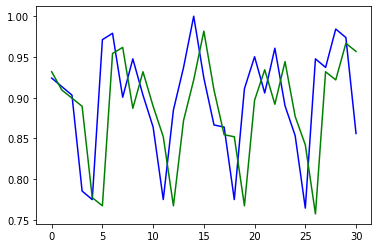

In [513]:
plt.plot(y_test, 'b')
plt.plot(y_pred, 'g')

In [514]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 4ms/step - loss: 0.0062


0.0062055643647909164

####LSTM

In [515]:
from keras.layers import LSTM

In [516]:
K.clear_session()
model = Sequential()

model.add(LSTM(20, input_shape=(1, 1)))

model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [517]:
X_test.shape

(31, 1)

In [518]:
X_train[:].shape

(149, 1)

In [519]:
X_train_t = X_train[:,None]
X_test_t = X_test[:, None]

In [520]:
model.fit(X_train_t, y_train,
          epochs=100, batch_size=2, verbose=1,
          callbacks=[early_stop])

Epoch 1/100
75/75 [==============================] - 0s 1ms/step - loss: 0.2049
Epoch 2/100
75/75 [==============================] - 0s 2ms/step - loss: 0.0728
Epoch 3/100
75/75 [==============================] - 0s 2ms/step - loss: 0.0335
Epoch 4/100
75/75 [==============================] - 0s 2ms/step - loss: 0.0267
Epoch 5/100
75/75 [==============================] - 0s 2ms/step - loss: 0.0223
Epoch 6/100
75/75 [==============================] - 0s 2ms/step - loss: 0.0183
Epoch 7/100
75/75 [==============================] - 0s 2ms/step - loss: 0.0149
Epoch 8/100
75/75 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 9/100
75/75 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 10/100
75/75 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 11/100
75/75 [==============================] - 0s 2ms/step - loss: 0.0079
Epoch 12/100
75/75 [==============================] - 0s 2ms/step - loss: 0.0074
Epoch 13/100
75/75 [=================

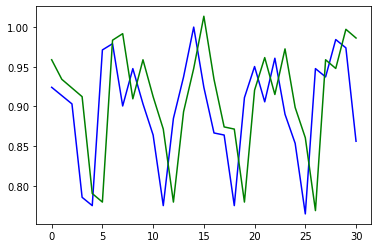

In [521]:
y_pred = model.predict(X_test_t)
plt.plot(y_test, 'b')
plt.plot(y_pred, 'g')

In [522]:
model.evaluate(X_test_t, y_test)

1/1 [==============================] - 0s 1ms/step - loss: 0.0068


0.006787178572267294

####Deep RNN

In [523]:
# Let's try a more complex network

model_rec_deep = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1) # can also use SimpleRNN layer here
])

model_rec_deep.compile(loss='mse', optimizer='adam')

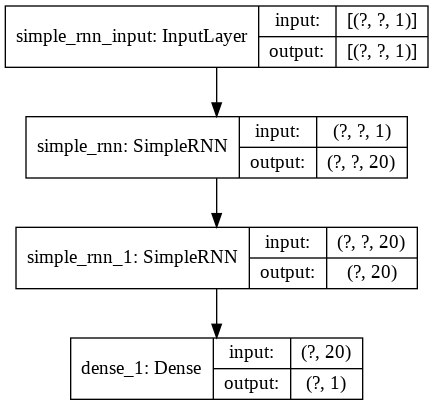

In [524]:
from tensorflow.keras.utils import plot_model

plot_model(model_rec_deep, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [525]:
h = model_rec_deep.fit(X_train_t, y_train, epochs=100, verbose=0)

In [526]:
model_rec_deep.evaluate(X_test_t, y_test)

1/1 [==============================] - 0s 3ms/step - loss: 0.0058


0.005756321828812361

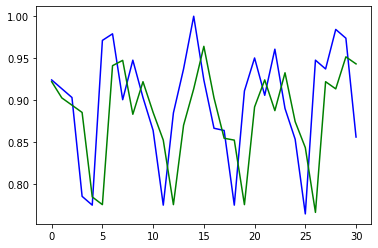

In [527]:
y_pred = model_rec_deep.predict(X_test_t)
plt.plot(y_test, 'b')
plt.plot(y_pred, 'g')

It is clear that Deep RNN gives the best result (MSE 0.0058)among all machine learning methods.
Due to the time limit, I didn't  calculate the prediction in July by using machine learning. 
However, we only have 181 samples in total. 
The sample size is so limited for the model to train the best result. 

But in the future, if we have large dataset we should definetly choose machine learning techinique as our solution.

# Conclusion and Insights

1. **Include an exploratory data analysis and report any finding on the dataset**

> The visualization and analysis of data could be found in the Data exploratory and Check for stationarity part.
    > The simple conclusion is that the data is non-stationary and the chats demand have a gradually increasing trend and weekly seasonality.

2. **Provide a recommendation on the number of nurses needed per day in July**

> Due to the research paper, on average across OECD countries, the [number of nurse]on per capita basis is 9 nurses per 1000  population (https://www.oecd-ilibrary.org/social-issues-migration-health/health-at-a-glance-2017/nurses_health_glance-2017-56-en;jsessionid=L-lTm1qZ7VeR4s-NXFRgxFc6.ip-10-240-5-164) And “In 2015, there were about three nurses per doctor on average across OECD countries, with about half of the countries reporting between two to four nurses per doctor”. 
And based on the graph in 2015, the number is 10 to 1000 in Canada.
So we could calculated a rough guess of the number of nurses needed per day.
> We have our final prediction of number of daily chats, we could divided them by 100, and get the daily demand of nurses. Which is shown in the df2. However, in case there are some emergency situation, we set the daily number of nurses at **5** or **6**. If we want to save the cost, we choose 5, on average the demand won't exceed 5. If we want to perform better customer services, we could choose 6.

3. **How would you evaluate the accuracy of your model?**
We using RMSE and MSE to evaluate the accuracy of SARIMA model. And we could also use AIC to test. For the Machine learning model, there are different loss method, but we usually choose MSE as well. 
4. **If the team starts using this model to staff the clinic, how would you evaluate the impact of this change?**
Firstly, we could evaluate by checking the daily demand of chats. After 

*   Firstly, we could evaluate by checking the daily demand of chats. After July, we could find whether the prediction model works well. 
If it does, we could update the dataset and run the prediction on the future.
*   Then, once we make sure that the prediction is reliable, the number of nurses and doctors might be affected. Right now the 5 or 6 is just the rough guess, if we want to figure out which number minimize the cost of labour but also satisfied our client demand. We could collect more data related to the waiting time before the chat room and before seeing a doctor and total length of stay for different users. All these elements could affect the demands of nurses and doctors. we could save the money on the labour cost. 
*   Next, we could collect the data from the customer feedback form. 
The rate from users reflect the satisfaction of their experiences. If in one day, most of users give poor feedback, we could check the members who is on duty that day. Whether they are doing bad, or there are a dramatically increasing in incoming patients that day etc... 

*   A good forecasting could also affect the future year plan.

5. **What are the next steps to improve the model’s accuracy and its impact on costs and quality of service?**
Just as I discussed above, we could collect more data to train the model. And once the dataset is big enough, we could use Machine learning technique to help us get more accurate result. 
The Next step is to collecting information from users(feedback) and also the nurses and doctors. Check whether there is too much idle running or not. Scrapped down the data directly from our system to load the information about waiting time. Using more healthcare management system. 



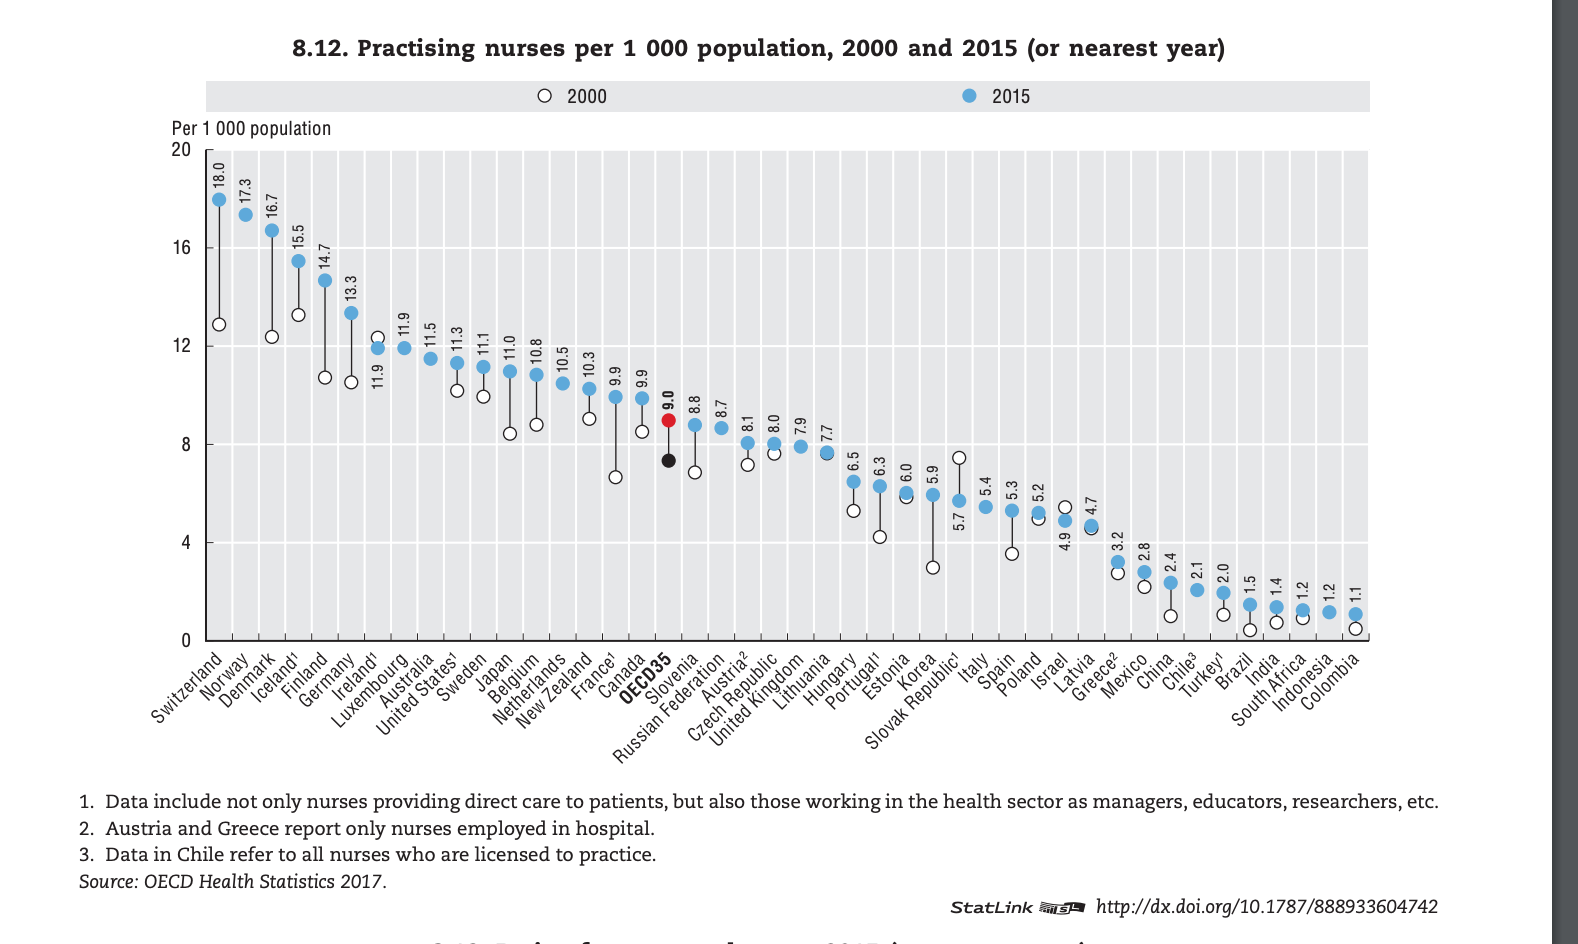

In [541]:
df2 = final_table["Predicted_Mean"]/100 
df2

0     3.783260
1     3.551269
2     4.141488
3     4.276576
4     4.234368
5     4.213790
6     4.111401
7     3.901696
8     3.639121
9     4.260426
10    4.345935
11    4.366649
12    4.340571
13    4.139752
14    3.970529
15    3.716614
16    4.329117
17    4.428665
18    4.431561
19    4.407040
20    4.234093
21    4.053408
22    3.797041
23    4.412036
24    4.507608
25    4.515550
26    4.490588
27    4.309749
28    4.132309
29    3.876636
30    4.490926
Name: Predicted_Mean, dtype: float64

Thanks to the 
> [Reference1] for time series examples(https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-one/)


> [Reference2]https://www.oecd-ilibrary.org/social-issues-migration-health/health-at-a-glance-2017/nurses_health_glance-2017-56-en;jsessionid=L-lTm1qZ7VeR4s-NXFRgxFc6.ip-10-240-5-164)



